In [1]:
!nvidia-smi -L

GPU 0: NVIDIA A100-SXM4-80GB (UUID: GPU-37c649b5-429c-aba9-822a-6c6724638a71)


In [2]:
%%capture
%pip install trl peft bitsandbytes

In [3]:
import os
import torch
import random
from typing import Any
from PIL import Image
from transformers import pipeline
from trl import SFTConfig, SFTTrainer
from peft import LoraConfig
from datasets import load_dataset, concatenate_datasets
from transformers import AutoProcessor, AutoModelForImageTextToText, BitsAndBytesConfig,TrainerCallback

In [4]:
# Load dental diagnosis dataset from Hugging Face
dataset = load_dataset("justacoderwhocodes/dental_diagnosis_dataset")

print("Dataset structure:")
print(dataset)

if "validation" not in dataset:
    dataset = dataset["train"].train_test_split(test_size=0.2, seed=42)
    data = {
        "train": dataset["train"],
        "validation": dataset["test"]
    }
else:
    data = {
        "train": dataset["train"],
        "validation": dataset["validation"]
    }

print(f"\nTrain samples: {len(data['train'])}")
print(f"Validation samples: {len(data['validation'])}")

# Inspect first sample
print("\nFirst sample structure:")
print(data['train'][0])

README.md:   0%|          | 0.00/448 [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/28.1M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1071 [00:00<?, ? examples/s]

Dataset structure:
DatasetDict({
    train: Dataset({
        features: ['filename', 'tooth', 'treatment', 'diagnosis', 'text'],
        num_rows: 1071
    })
})

Train samples: 856
Validation samples: 215

First sample structure:
{'filename': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=448x448 at 0x7B6F63447500>, 'tooth': 'third_molar', 'treatment': 'extraction', 'diagnosis': 'Partially erupted/impacted third molar which needs extraction', 'text': 'Partially erupted/impacted third molar which needs extraction; recommended treatment: extraction'}


In [5]:
# Define question templates for random selection
QUESTION_TEMPLATES = [
    "Analyze this dental image and provide findings.",
    "Analyze this dental radiograph and provide the diagnosis.",
    "What condition is shown in this dental radiograph?"
]


def format_dental_data(example: dict[str, Any]) -> dict[str, Any]:
    """Format dental data for MedGemma training with image + diagnosis."""
    selected_question = random.choice(QUESTION_TEMPLATES)
    example["messages"] = [
        {
            "role": "user",
            "content": [
                {"type": "image"},
                {"type": "text", "text": selected_question},
            ],
        },
        {
            "role": "assistant",
            "content": [
                {"type": "text", "text": example["text"]},
            ],
        },
    ]

    return example


# Set random seed for reproducibility
random.seed(42)

In [6]:
NUM_VARIATIONS = 3

all_train_variations = []
for i in range(NUM_VARIATIONS):
    random.seed(42 + i)
    varied_train = data["train"].map(format_dental_data)
    all_train_variations.append(varied_train)


data["train"] = concatenate_datasets(all_train_variations) # Combine all variations

random.seed(42)
data["validation"] = data["validation"].map(format_dental_data)

print(f"Expanded training set: {len(data['train'])} examples ({len(data['train']) // NUM_VARIATIONS} original × {NUM_VARIATIONS} variations)")
print(f"Validation set: {len(data['validation'])} examples")
print("\nExample formatted data:")
print(data["train"][0]["messages"])

Map:   0%|          | 0/856 [00:00<?, ? examples/s]

Map:   0%|          | 0/215 [00:00<?, ? examples/s]

Expanded training set: 2568 examples (856 original × 3 variations)
Validation set: 215 examples

Example formatted data:
[{'content': [{'text': None, 'type': 'image'}, {'text': 'What condition is shown in this dental radiograph?', 'type': 'text'}], 'role': 'user'}, {'content': [{'text': 'Partially erupted/impacted third molar which needs extraction; recommended treatment: extraction', 'type': 'text'}], 'role': 'assistant'}]


In [7]:
model_id = "google/medgemma-1.5-4b-it"

In [8]:
# model_kwargs = dict(
#     attn_implementation="eager",
#     dtype=torch.bfloat16,
#     device_map="auto",
# )

# model_kwargs["quantization_config"] = BitsAndBytesConfig(
#     load_in_4bit=True,
#     bnb_4bit_use_double_quant=True,
#     bnb_4bit_quant_type="nf4",
#     bnb_4bit_compute_dtype=model_kwargs["dtype"],
#     bnb_4bit_quant_storage=model_kwargs["dtype"],
# )

model_kwargs = dict(
    attn_implementation="eager",
    torch_dtype=torch.bfloat16,
    device_map="auto",
    quantization_config=None,  # Disable quantization for full fine-tuning
)

model = AutoModelForImageTextToText.from_pretrained(model_id, **model_kwargs)
processor = AutoProcessor.from_pretrained(model_id)
processor.tokenizer.padding_side = "right"

config.json:   0%|          | 0.00/2.55k [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json:   0%|          | 0.00/90.6k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/883 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/115 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/70.0 [00:00<?, ?B/s]

chat_template.jinja:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

The image processor of type `Gemma3ImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. 


tokenizer_config.json:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

In [9]:
sample = data['validation'][0]
test_image = sample["filename"].convert("RGB")

In [10]:
# peft_config = LoraConfig(
#     r=16,
#     lora_alpha=32,
#     target_modules="all-linear",
#     lora_dropout=0.05,
#     bias="all",
#     task_type="CAUSAL_LM",
# )

In [11]:
def collate_fn(examples: list[dict[str, Any]]):
    texts = []
    images = []
    for example in examples:
        images.append([example["filename"].convert("RGB")])
        texts.append(processor.apply_chat_template(
            example["messages"], add_generation_prompt=False, tokenize=False
        ).strip())

    batch = processor(text=texts, images=images, return_tensors="pt", padding=True)

    labels = batch["input_ids"].clone()

    image_token_id = processor.tokenizer.convert_tokens_to_ids(
        processor.tokenizer.special_tokens_map["boi_token"]
    )

    labels[labels == processor.tokenizer.pad_token_id] = -100
    labels[labels == image_token_id] = -100
    labels[labels == 262144] = -100

    batch["labels"] = labels
    return batch

In [12]:
num_train_epochs = 5
learning_rate = 1e-5
batch_size = 4
eval_steps = 50

In [13]:
args = SFTConfig(
    output_dir="medgemma-4b-it-sft-lora-dental-diagnosis",
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    gradient_accumulation_steps=2, #effective batch size of 8
    gradient_checkpointing=True,
    optim="adamw_torch_fused",
    logging_steps=10,
    save_strategy="steps",
    eval_strategy="steps",
    eval_steps=eval_steps,
    learning_rate=learning_rate,
    bf16=True,
    max_grad_norm=0.3,
    warmup_ratio=0.1,
    lr_scheduler_type="cosine",
    weight_decay=0.01,

    save_steps=100,
    hub_strategy="every_save",
    push_to_hub=True,
    hub_model_id="justacoderwhocodes/medgemma-dental-diagnosis-finetune",

    gradient_checkpointing_kwargs={"use_reentrant": False},
    dataset_kwargs={"skip_prepare_dataset": True},
    remove_unused_columns=False,
    label_names=["labels"],
    load_best_model_at_end=True,
    metric_for_best_model="loss",
    greater_is_better=False
)

warmup_ratio is deprecated and will be removed in v5.2. Use `warmup_steps` instead.


In [14]:
class GenerationCallback(TrainerCallback):
    def __init__(self, processor, dataset, prompt_text, every_n_steps=100):
        self.processor = processor
        self.dataset = dataset
        self.prompt_text = prompt_text
        self.every_n_steps = every_n_steps
        self.rng = random.Random(42)  # Reproducible but can change per step

    def on_step_end(self, args, state, control, model=None, **kwargs):
        if state.global_step % self.every_n_steps == 0:
            # Random sample from dataset each time
            idx = self.rng.randint(0, len(self.dataset) - 1)
            sample = self.dataset[idx]
            test_image = sample["filename"].convert("RGB")
            ground_truth = sample["text"]

            print(f"\n{'='*60}")
            print(f"Generation check at step {state.global_step} (sample index: {idx})")
            print(f"{'='*60}")

            was_training = model.training
            model.eval()

            try:
                messages = [
                    {
                        "role": "user",
                        "content": [
                            {"type": "image"},
                            {"type": "text", "text": self.prompt_text},
                        ],
                    },
                ]

                text = self.processor.apply_chat_template(
                    messages, add_generation_prompt=True, tokenize=False
                )

                inputs = self.processor(
                    text=[text],
                    images=[[test_image]],
                    return_tensors="pt",
                    padding=True
                )

                device = next(model.parameters()).device
                inputs = {k: v.to(device) for k, v in inputs.items()}

                with torch.no_grad():
                    outputs = model.generate(
                        **inputs,
                        max_new_tokens=150,
                        do_sample=False,
                        pad_token_id=self.processor.tokenizer.eos_token_id
                    )

                input_length = inputs["input_ids"].shape[1]
                generated_text = self.processor.batch_decode(
                    outputs[:, input_length:], skip_special_tokens=True
                )[0]

                print(f"\n{'-'*60}")
                print(f"FORMATTED INPUT:")
                print(f"{'-'*60}")
                print(text[:500] + "..." if len(text) > 500 else text)
                print(f"\n{'-'*60}")
                print(f"PROMPT: {self.prompt_text}")
                print(f"GROUND TRUTH: {ground_truth}")
                print(f"GENERATED OUTPUT: {generated_text}")
                print(f"{'='*60}\n")

                try:
                    from IPython.display import display
                    print("Test image:")
                    display(test_image)
                except:
                    pass
            finally:
                if was_training:
                    model.train()

        return control

In [15]:
gen_callback = GenerationCallback(
    processor=processor,
    dataset=data['validation'],
    prompt_text="Analyze this dental radiograph and provide findings.",
    every_n_steps=eval_steps
)

In [16]:
def run_inference_sample(processor, model, dataset, sample_idx=None, prompt_text=None):
    import random

    if sample_idx is None:
        sample_idx = random.randint(0, len(dataset) - 1)

    sample = dataset[sample_idx]
    test_image = sample["filename"].convert("RGB")
    ground_truth = sample["text"]

    if prompt_text is None:
        prompt_text = "Analyze this dental radiograph and provide findings."

    messages = [
        {
            "role": "user",
            "content": [
                {"type": "image"},
                {"type": "text", "text": prompt_text},
            ],
        },
    ]

    text = processor.apply_chat_template(
        messages, add_generation_prompt=True, tokenize=False
    )

    inputs = processor(
        text=[text],
        images=[[test_image]],
        return_tensors="pt",
        padding=True
    )

    device = next(model.parameters()).device
    inputs = {k: v.to(device) for k, v in inputs.items()}

    model.eval()
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=150,
            do_sample=False,
            pad_token_id=processor.tokenizer.eos_token_id
        )

    input_length = inputs["input_ids"].shape[1]
    generated_text = processor.batch_decode(
        outputs[:, input_length:], skip_special_tokens=True
    )[0]

    print(f"Sample index: {sample_idx}")
    print(f"Prompt text: {prompt_text}")
    print(f"Ground Truth: {ground_truth}")
    print(f"Generated Output: {generated_text}")

In [17]:
run_inference_sample(processor, model, data['validation'])

Sample index: 67
Prompt text: Analyze this dental radiograph and provide findings.
Ground Truth: Deep proximal cavity involving pulp, caries is deep and is touching the pulp chamber; recommended treatment: rct
Generated Output: Based on the provided dental radiograph, here are the key findings:

*   **Anterior teeth:** The anterior teeth (incisors and canines) appear relatively normal in terms of their overall structure and alignment.
*   **Root morphology:** The root morphology of the anterior teeth appears generally normal.
*   **Occlusal surface:** The occlusal surfaces of the anterior teeth are visible.
*   **No obvious pathology:** There are no obvious signs of caries, periapical pathology, or significant bone loss in the visualized area.

**Disclaimer:** This analysis is based solely on the provided image and should not be considered a definitive diagnosis. A comprehensive dental examination by a qualified dentist is necessary for accurate diagnosis and treatment


In [18]:
trainer = SFTTrainer(
    model=model,
    args=args,
    train_dataset=data["train"],
    eval_dataset=data["validation"],
    # peft_config=peft_config,
    processing_class=processor,
    data_collator=collate_fn,
    callbacks=[gen_callback]
)

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 1, 'bos_token_id': 2, 'pad_token_id': 0}.


Step,Training Loss,Validation Loss
50,0.783258,0.540901
100,0.418859,0.470025
150,0.356078,0.467483
200,0.417729,0.462483
250,0.427361,0.452394
300,0.582852,0.498765
350,0.312960,0.466123
400,0.308906,0.457114
450,0.322078,0.444785
500,0.270672,0.408184



Generation check at step 100 (sample index: 163)

------------------------------------------------------------
FORMATTED INPUT:
------------------------------------------------------------
<bos><start_of_turn>user
<start_of_image>Analyze this dental radiograph and provide findings.<end_of_turn>
<start_of_turn>model


------------------------------------------------------------
PROMPT: Analyze this dental radiograph and provide findings.
GROUND TRUTH: Impacted third molar; recommended treatment: extraction
GENERATED OUTPUT: Impacted third molar; recommended treatment: extraction

Test image:


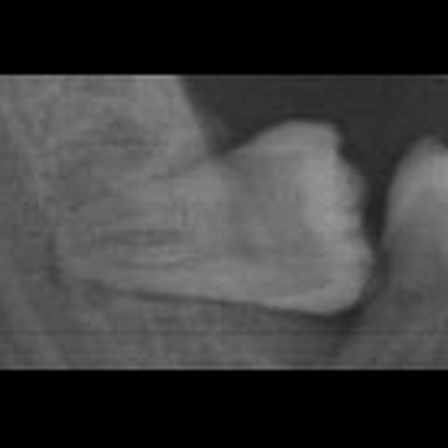


Generation check at step 200 (sample index: 28)

------------------------------------------------------------
FORMATTED INPUT:
------------------------------------------------------------
<bos><start_of_turn>user
<start_of_image>Analyze this dental radiograph and provide findings.<end_of_turn>
<start_of_turn>model


------------------------------------------------------------
PROMPT: Analyze this dental radiograph and provide findings.
GROUND TRUTH: Root canal treated tooth needs to be restored with a crown; recommended treatment: restoration
GENERATED OUTPUT: Root canal treated tooth needs to be restored with a crown; recommended treatment: restoration

Test image:


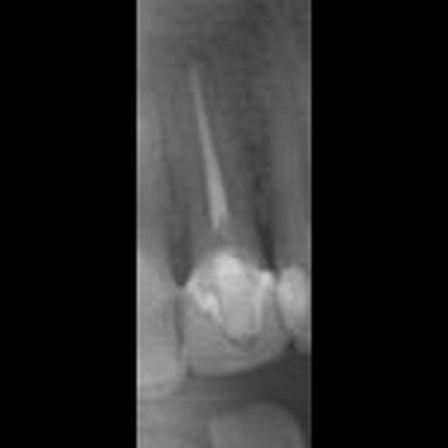


Generation check at step 300 (sample index: 6)

------------------------------------------------------------
FORMATTED INPUT:
------------------------------------------------------------
<bos><start_of_turn>user
<start_of_image>Analyze this dental radiograph and provide findings.<end_of_turn>
<start_of_turn>model


------------------------------------------------------------
PROMPT: Analyze this dental radiograph and provide findings.
GROUND TRUTH: Retained deciduous tooth with resorbed roots requires extraction; recommended treatment: extraction
GENERATED OUTPUT: Retained deciduous tooth with resorbed roots; recommended treatment: extraction

Test image:


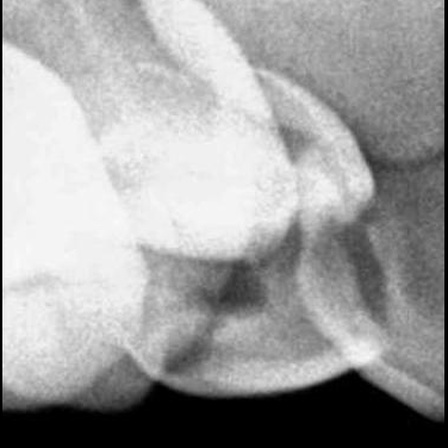


Generation check at step 400 (sample index: 189)

------------------------------------------------------------
FORMATTED INPUT:
------------------------------------------------------------
<bos><start_of_turn>user
<start_of_image>Analyze this dental radiograph and provide findings.<end_of_turn>
<start_of_turn>model


------------------------------------------------------------
PROMPT: Analyze this dental radiograph and provide findings.
GROUND TRUTH: Root canal treated tooth needs to be restored with a crown; recommended treatment: restoration
GENERATED OUTPUT: Root canal treated tooth needs to be restored with a crown; recommended treatment: restoration

Test image:


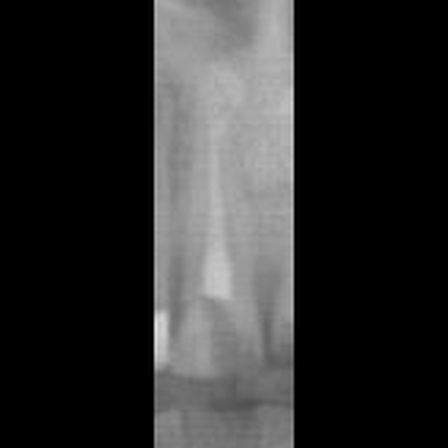


Generation check at step 500 (sample index: 70)

------------------------------------------------------------
FORMATTED INPUT:
------------------------------------------------------------
<bos><start_of_turn>user
<start_of_image>Analyze this dental radiograph and provide findings.<end_of_turn>
<start_of_turn>model


------------------------------------------------------------
PROMPT: Analyze this dental radiograph and provide findings.
GROUND TRUTH: Fractured coronal structure; recommended treatment: rct
GENERATED OUTPUT: Proximal caries; recommended treatment: restoration

Test image:


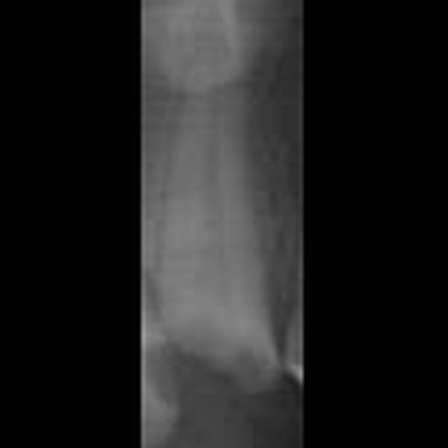

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [19]:
trainer.train()

## Save and Test Model

In [20]:
trainer.save_model()

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...-diagnosis/tokenizer.json:  25%|##4       | 8.28MB / 33.4MB            

  ...agnosis/model.safetensors:   0%|          |  112kB / 8.60GB            

  ...agnosis/training_args.bin:  26%|##5       | 1.48kB / 5.78kB            

In [ ]:
del model
del trainer
torch.cuda.empty_cache()

## Testing

In [21]:
ft_pipe = pipeline(
    "image-text-to-text",
    model=args.output_dir,
    processor=processor,
    dtype=torch.bfloat16,
)
ft_pipe.model.generation_config.do_sample = False
ft_pipe.model.generation_config.pad_token_id = processor.tokenizer.eos_token_id
processor.tokenizer.padding_side = "left"

`torch_dtype` is deprecated! Use `dtype` instead!


Loading weights:   0%|          | 0/883 [00:00<?, ?it/s]

In [22]:
test_samples = data["validation"].select(range(5))

In [24]:
for i, sample in enumerate(test_samples):
    print(f"\n{'='*60}")
    print(f"Sample {i+1}")
    print(f"{'='*60}")

    prompt_text = "Analyze this dental radiograph and provide findings."

    # Create test message with image inside content
    messages = [
        {
            "role": "user",
            "content": [
                {"type": "image", "image": sample["filename"]},
                {"type": "text", "text": prompt_text},
            ],
        },
    ]

    # Apply chat template to show formatted input
    formatted_input = processor.apply_chat_template(
        messages, add_generation_prompt=True, tokenize=False
    )

    # Get prediction - pass only messages, not separate images
    output = ft_pipe(
        text=messages,
        max_new_tokens=150,
        return_full_text=False,
    )

    # Display results
    predicted_text = output[0]["generated_text"]
    ground_truth = sample["text"]

    print(f"\n{'-'*60}")
    print(f"FORMATTED INPUT:")
    print(f"{'-'*60}")
    print(formatted_input[:500] + "..." if len(formatted_input) > 500 else formatted_input)
    print(f"\n{'-'*60}")
    print(f"PROMPT: {prompt_text}")
    print(f"GROUND TRUTH: {ground_truth}")
    print(f"GENERATED OUTPUT: {predicted_text}")
    print(f"{'='*60}")

Passing `generation_config` together with generation-related arguments=({'max_new_tokens'}) is deprecated and will be removed in future versions. Please pass either a `generation_config` object OR all generation parameters explicitly, but not both.
Both `max_new_tokens` (=150) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



Sample 1


Both `max_new_tokens` (=150) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



------------------------------------------------------------
FORMATTED INPUT:
------------------------------------------------------------
<bos><start_of_turn>user
<start_of_image>Analyze this dental radiograph and provide findings.<end_of_turn>
<start_of_turn>model


------------------------------------------------------------
PROMPT: Analyze this dental radiograph and provide findings.
GROUND TRUTH: Large restoration involving and touching pulp; recommended treatment: rct
GENERATED OUTPUT: Deep caries involving pulp; recommended treatment: rct

Sample 2


Both `max_new_tokens` (=150) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



------------------------------------------------------------
FORMATTED INPUT:
------------------------------------------------------------
<bos><start_of_turn>user
<start_of_image>Analyze this dental radiograph and provide findings.<end_of_turn>
<start_of_turn>model


------------------------------------------------------------
PROMPT: Analyze this dental radiograph and provide findings.
GROUND TRUTH: Proximal caries away from pulp; recommended treatment: restoration
GENERATED OUTPUT: Proximal caries; recommended treatment: restoration

Sample 3


Both `max_new_tokens` (=150) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



------------------------------------------------------------
FORMATTED INPUT:
------------------------------------------------------------
<bos><start_of_turn>user
<start_of_image>Analyze this dental radiograph and provide findings.<end_of_turn>
<start_of_turn>model


------------------------------------------------------------
PROMPT: Analyze this dental radiograph and provide findings.
GROUND TRUTH: caries away from pulp; recommended treatment: restoration
GENERATED OUTPUT: Deep caries involving pulp; recommended treatment: rct

Sample 4


Both `max_new_tokens` (=150) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



------------------------------------------------------------
FORMATTED INPUT:
------------------------------------------------------------
<bos><start_of_turn>user
<start_of_image>Analyze this dental radiograph and provide findings.<end_of_turn>
<start_of_turn>model


------------------------------------------------------------
PROMPT: Analyze this dental radiograph and provide findings.
GROUND TRUTH: Retained deciduous tooth with resorbed roots; recommended treatment: extraction
GENERATED OUTPUT: Retained deciduous tooth with resorbed roots; recommended treatment: extraction

Sample 5

------------------------------------------------------------
FORMATTED INPUT:
------------------------------------------------------------
<bos><start_of_turn>user
<start_of_image>Analyze this dental radiograph and provide findings.<end_of_turn>
<start_of_turn>model


------------------------------------------------------------
PROMPT: Analyze this dental radiograph and provide findings.
GROUND TRUTH: 